In [1]:
#imports
import random as rd
import numpy as np
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
# parameters custom
en = 3
ch = 3
pckts = 100
tol = 0.2
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
error_matrix = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
rate = np.array([10,4,8])
lr = 0.01

In [3]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [4]:
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
linprog_succ = []
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(np.zeros(pckts))
t = 0

In [5]:
T = 100
sprob = steady_state_prob(p[t])
while t < T:
    enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[t]]))
    b.append(np.zeros(pckts))
    for i in range(pckts):
        b[t+1][i] = bernoulli(error_matrix[enc[t+1]][chnl[t+1]])
    # print(enc[t+1],chnl[t+1],np.sum(b[t+1])/pckts)
    tprob = np.zeros(ch)
    ones = np.sum(b[t+1])
    for j in range(ch):
        tprob[j] = (ones/error_matrix[enc[t+1]][j]) + ((pckts-ones)/(1-error_matrix[enc[t+1]][j]))
    # tprob = np.exp(tprob - np.mean(tprob))
    tprob = row_normalize([tprob])[0]
    temp = np.zeros((ch,ch))
    for i in range(ch):
        for j in range(ch):
            temp[i,j] = p[t][i,j] + lr*((sprob[i]*tprob[j]) - p[t][i,j])
    p.append(row_normalize(temp))
    sprob = steady_state_prob(p[t+1])
    ub = []
    for i in range(en):
        ub.append(np.dot(error_matrix[i],sprob))
    ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1e-5})
    linprog_succ.append(ltemp.success)
    lamda.append(ltemp.x)
    emp_err.append(np.dot(ltemp.x,ub))
    emp_rate.append(np.dot(ltemp.x,rate))
    print(t,emp_err[t+1],emp_rate[t+1],ltemp.success)
    t+=1

0 0.2 4.002394509424343 True
1 0.19999999999999996 4.002905046304102 True
2 0.2 4.003464465819181 True
3 0.19999999999999998 4.005699812188417 True
4 0.2 4.00607620793038 True
5 0.2 4.005820006830416 True
6 0.2 4.008166241380552 True
7 0.19999999999999998 4.008773598200371 True
8 0.19999999999999998 4.011145688691965 True
9 0.19999999999999998 4.013392580344013 True
10 0.20000000000000004 4.013456478324848 True
11 0.2 4.0134294579240875 True
12 0.2 4.015727418328754 True
13 0.2 4.016403992078456 True
14 0.2 4.018633436719153 True
15 0.2 4.018874009544355 True
16 0.19999999999999998 4.01925988734522 True
17 0.2 4.0214128481240685 True
18 0.20000000000000004 4.02187668689406 True
19 0.19999999999999998 4.0222525115328915 True
20 0.20000000000000004 4.0221778128494545 True
21 0.20000000000000004 4.022139653169666 True
22 0.19999999999999998 4.02445355903808 True
23 0.19999999999999998 4.024208159266894 True
24 0.2 4.026446283958195 True
25 0.19999999999999998 4.026698147662892 True
26 0.2

In [6]:
print(p[0])
print(p[t])
print(P)
print(lamda[t])

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
[[0.32537843 0.31531362 0.35930795]
 [0.32548675 0.31555804 0.3589552 ]
 [0.32501654 0.31449574 0.36048772]]
[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[0.01484152 0.98515848 0.        ]


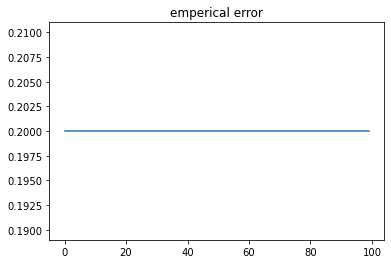

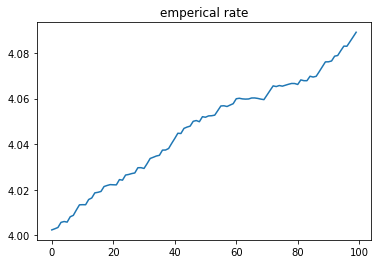

In [7]:
plt.plot(emp_err[1:])
plt.title('emperical error')
plt.show()
plt.plot(emp_rate[1:])
plt.title('emperical rate')
plt.show()

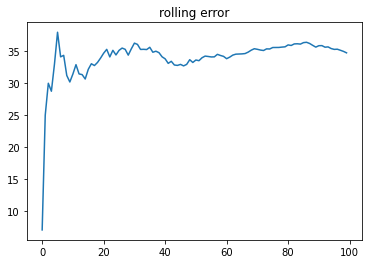

In [15]:
ones_plot = pckts - np.sum(b,axis=1)
for i in range(1,len(ones_plot)):
    ones_plot[i] += (ones_plot[i-1]*(i-1))
    ones_plot[i] =ones_plot[i]/i
plt.plot(ones_plot[1:])
plt.title('rolling error')
plt.show()

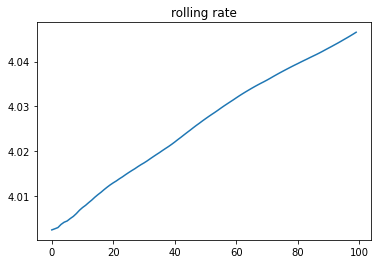

In [9]:
rate_plot = np.copy(emp_rate)
for i in range(1,len(ones_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[1:])
plt.title('rolling rate')
plt.show()

In [ ]:
x = np.array([-1,-2,-3])
x = x - 2*np.min(x)
x = -1*x
print(x)
row_normalize([x])[0]

In [10]:
sprob = steady_state_prob(P)
ub = []
for i in range(en):
    ub.append(np.dot(error_matrix[i],sprob))
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))

4.327868852459018 1.0 [0.] True 0.2


In [11]:
np.sum([[1,2],[3,4]],axis=1)

array([3, 7])

In [ ]:
np.ones(3)